In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import math
import hvplot.pandas
from MCForecastTools import MCSimulation

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Create empty disctionary of user's portfolio for analisys 
portfolio = {}

# Get portfolio tickers and shares from a user, defined period user analysis and fetch closing prices for a portfolio.
# Run Infinite loop "while True" to get as much stock tickers as user wishes to analysis and break when finished "Done". 
# Use input function for user interactions 
while True:
    
#The use of upper() in the provided code is to convert the user-inputted stock symbol to uppercase letters.
    stock = input("Enter a stock symbol (or 'done' to finish): ").upper() 
    if stock == 'DONE':
        break
    quantity = float(input(f"Enter the quantity of {stock}: "))
    portfolio[stock] = quantity

# Locate and convert the ".keys()" and ".values()" in dictionary to the list.
portfolio_tickers = list(portfolio.keys())
stock_shares = list(portfolio.values())

# Create empty disctionaty for historical_data to save all downloaded data.
# Run "for" loop to iterate through each stock ticker in the list and download closing data in defined period of time.
historical_data = {}
for stock_symbol in portfolio.keys():
    stock_data = yf.download(stock_symbol, period="5y")
    historical_data[stock_symbol] = stock_data['Close']


Enter a stock symbol (or 'done' to finish):  v
Enter the quantity of V:  12
Enter a stock symbol (or 'done' to finish):  xom
Enter the quantity of XOM:  15
Enter a stock symbol (or 'done' to finish):  sq
Enter the quantity of SQ:  18
Enter a stock symbol (or 'done' to finish):  ups
Enter the quantity of UPS:  20
Enter a stock symbol (or 'done' to finish):  wm
Enter the quantity of WM:  23
Enter a stock symbol (or 'done' to finish):  vici
Enter the quantity of VICI:  25
Enter a stock symbol (or 'done' to finish):  done


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
def portfolio_value(portfolio_tickers, stock_shares):
    try:
        # Download historical stock prices
        data = yf.download(portfolio_tickers, period="1d")['Close']
        
        # Get the latest prices
        current_prices = data.iloc[-1]
        
        # Calculate the value of each stock
        stock_values = current_prices * pd.Series(portfolio)
        
        # Calculate the total portfolio value
        portfolio_value = stock_values.sum()
        
        return portfolio_value
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

# Calculate portfolio value
current_portfolio_value = portfolio_value(portfolio_tickers, stock_shares)

# Display the current portfolio value
print(f"\nCurrent Portfolio Value: ${current_portfolio_value:.2f}")

[*********************100%%**********************]  6 of 6 completed

Current Portfolio Value: $14036.68


[*********************100%%**********************]  6 of 6 completed


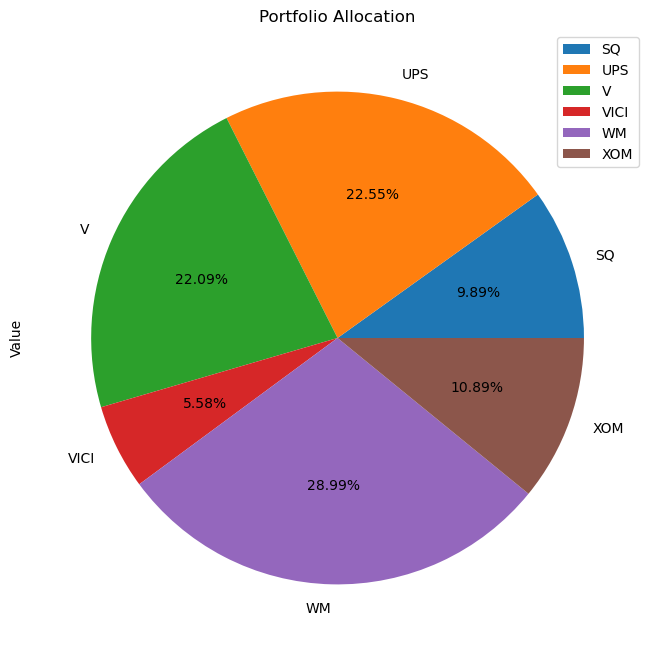

In [4]:
# Fetch stocks closing prices in the portfolio for period of one day .
data = yf.download(portfolio_tickers, period="1d")['Close'] 
current_prices = data.iloc[-1]

# Locate shares owned and calculate current values of each stock in the portfolio.
stock_shares = pd.Series(stock_shares, index=portfolio_tickers)
each_stock_value = pd.DataFrame((current_prices * stock_shares).round(2))

# Calculate percentage of each stock in the portfolio.
percentage_of_portfolio = ((each_stock_value / current_portfolio_value) * 100).round(2)

# Combine stocks values and percetage allocation in to one dataframe, define columns name and plot pie chart.
portfolio_summary = pd.concat([each_stock_value, percentage_of_portfolio], axis=1)
portfolio_summary.columns = ['Value', 'Percentage']
portfolio_summary.plot.pie(y='Value', 
                           autopct='%1.2f%%', 
                           title="Portfolio Allocation", 
                           figsize=(8, 8))
plt.legend(loc='upper right')

# Save plot in the images folder.
plt.savefig('images/portfolio_allocation.png')

In [5]:
# Fetch the closing data for Sp 500, Define period you wish to work with.
sp500_data = yf.download('^GSPC',  period="5y") 
sp500_closing_prices = sp500_data['Close']

# Convert to pandas DataFrame, Rename cloumn name to SP500.
sp500_closing_prices = pd.DataFrame(sp500_closing_prices)
sp500_closing_prices.columns = ['SP500']

#  Calculate daily retuns of the Market and drop na.
sp500_returns = sp500_closing_prices.pct_change().dropna()

# Convert historical data of portfolio to pandas DataFrame and Calculate daily retuns of portfolio and drop na. 
historical_data = pd.DataFrame(historical_data)
portfolio_returns = historical_data.pct_change().dropna()

# Combine market and portfolio returns to one DataFrame.
combined_returns = pd.merge(sp500_returns, portfolio_returns, on='Date')
combined_returns

[*********************100%%**********************]  1 of 1 completed


,SP500,V,XOM,SQ,UPS,WM,VICI
Date,,,,,,,
2018-12-26,0.049594,0.069827,0.047779,0.090694,0.074758,0.038710,0.031632
2018-12-27,0.008563,0.013668,0.004371,0.015004,0.012111,0.013342,-0.012910
2018-12-28,-0.001242,-0.008105,-0.011169,-0.004987,-0.012784,-0.001703,0.011989
2018-12-31,0.008492,0.007637,0.000293,0.003938,0.010359,0.011825,0.011309
2019-01-02,0.001268,0.007428,0.021997,0.019790,-0.003281,-0.003034,-0.015975
...,...,...,...,...,...,...,...
2023-12-18,0.004528,0.001318,0.007433,-0.004447,-0.008408,0.017645,-0.003510
2023-12-19,0.005866,0.006270,0.013182,0.046427,0.000309,-0.004785,0.018252
2023-12-20,-0.014684,-0.011077,-0.016701,-0.015522,-0.028833,-0.005770,-0.021384


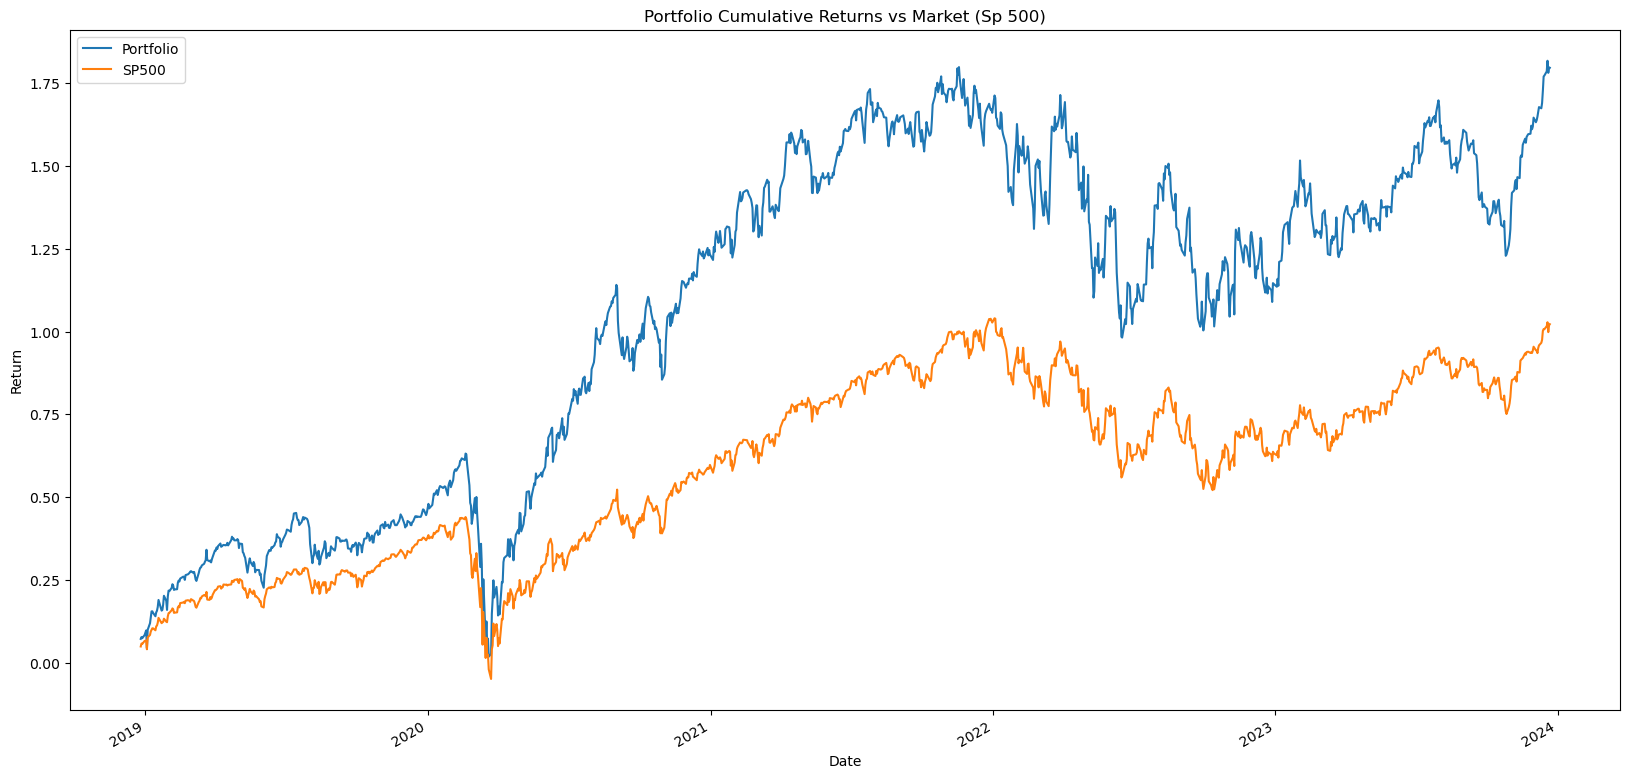

In [137]:
# Sum the average returns of the portfolio and calculate cumulative returns of the portfolio and then plot it.
portfolio_average_returns = portfolio_returns.mean(axis=1)
portfolio_cumulative_returns = (1 + portfolio_average_returns).cumprod() - 1
ax = portfolio_cumulative_returns.plot(figsize=(20,10), 
                        ylabel='Return',
                        title='Portfolio Cumulative Returns vs Market (Sp 500)',
                        label='Portfolio',
                        legend=True)
# Calculate cumulative returns of th market and plot it against our portfolio.
spy500_cumulative_returns = (1 + sp500_returns).cumprod() - 1
spy500_cumulative_returns.plot(ax=ax, label='SP500', legend=True)

# Save plot in the images folder.
plt.savefig('images/cumulative_returns.png')

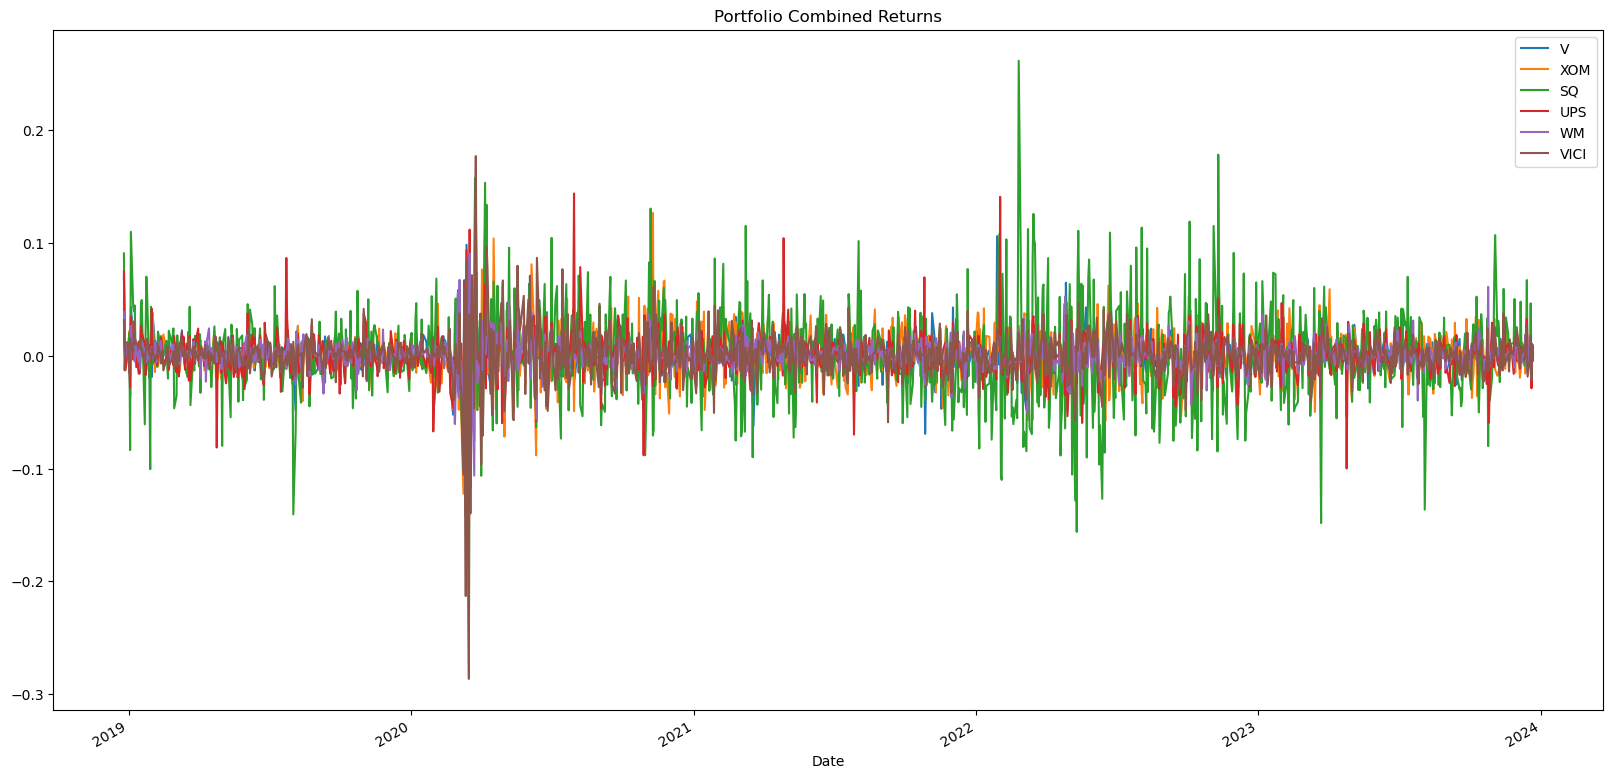

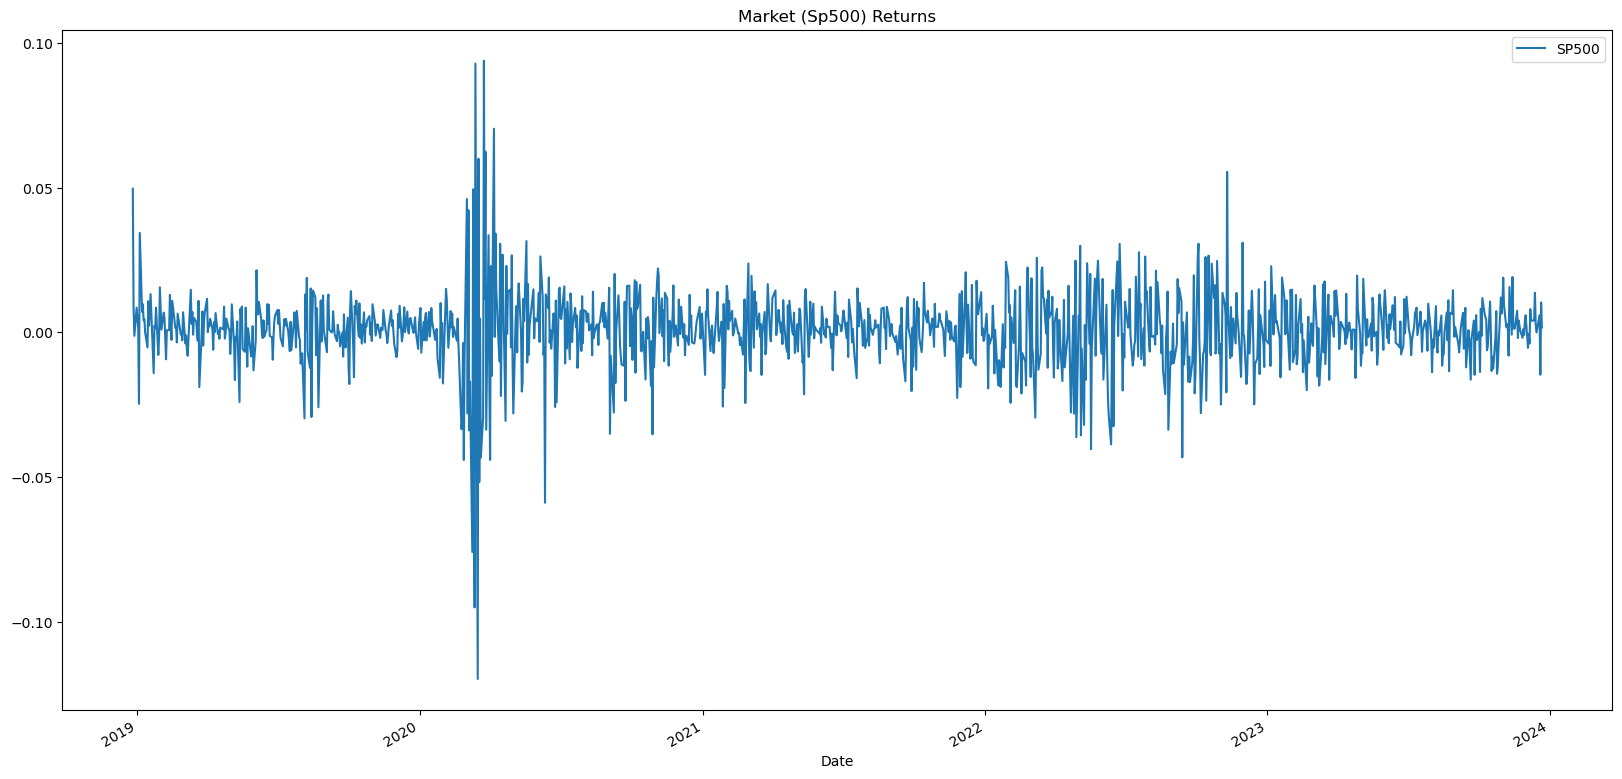

In [6]:
portfolio_returns.plot(figsize=(20,10),title='Portfolio Combined Returns', legend=True)
sp500_returns.plot(figsize=(20,10),title='Market (Sp500) Returns', legend=True)
plt.savefig('images/portfolio_returns.png')
plt.savefig('images/sp500_returns.png')

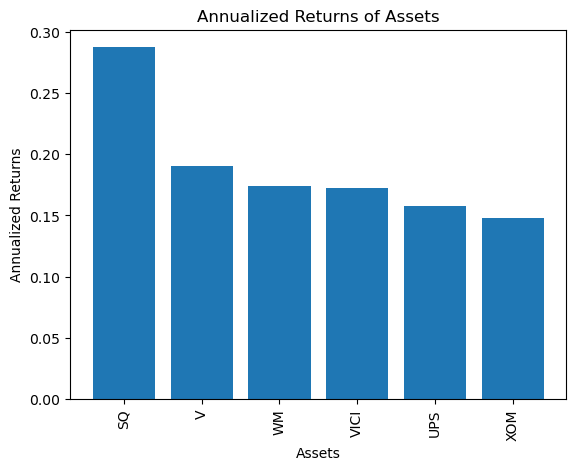

In [7]:
# define the risk free rate
risk_free_rate = 0.04/252 # annualized yield of 3-month Treasury bill divided by 252 trading days

# calculate the excess returns of each stock in the portfolio
excess_returns = portfolio_returns * stock_shares - risk_free_rate


# Calculate the annual returns
annual_daily_returns = portfolio_returns.mean() * 252
annual_excess_returns = excess_returns.mean() * 252

# Calculate the daily standard deviations
portfolio_returns_std = portfolio_returns.std()

# CAluculating the excess returns
excess_returns_std = excess_returns.std()


######### annual STD

# Calculate the annualized standard deviation (252 trading days)
stock_annualized_std = portfolio_returns_std * np.sqrt(252)
portfolio_annualized_std = excess_returns_std * np.sqrt(252)

# Calculate the stock risk
annual_stock_risk = portfolio_returns_std * math.sqrt(252)
annual_excess_risk = excess_returns_std * math.sqrt(252)

# Sorted the data in decending order
sorted_annual_returns = annual_daily_returns.sort_values(ascending=False)
sorted_annual_excess_returns = annual_excess_returns.sort_values(ascending=False)


# plot the sorted annualized returns of stock
plt.bar(sorted_annual_returns.index, sorted_annual_returns)
plt.ylabel("Annualized Returns")
plt.xlabel('Assets')

plt.xticks(rotation=90)
plt.title('Annualized Returns of Assets')
plt.savefig('images/annualized_returns.png')

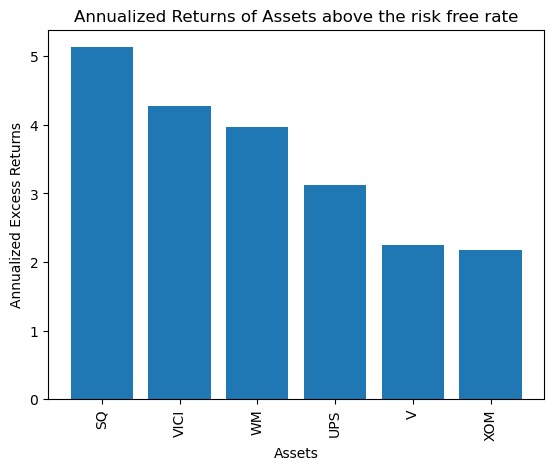

In [8]:
# Plot of the excess annual returns
# plot the sorted annualized returns of stock
plt.bar(sorted_annual_excess_returns.index, sorted_annual_excess_returns)
plt.ylabel("Annualized Excess Returns")
plt.xlabel('Assets')
plt.xticks(rotation=90)
plt.title('Annualized Returns of Assets above the risk free rate')
plt.show()

In [9]:
# creat a dataframe to store the annual returns, annual risks, annual excess returns and company ticker and new column for the ratio

risk_df = pd.DataFrame()
risk_df['Expected Annual Returns'] = annual_daily_returns
risk_df['Expected Annual Risk'] = annual_stock_risk
risk_df['Expected Annual Excess Returns'] = annual_excess_returns
risk_df['Stock'] = portfolio_tickers
risk_df['Ratio'] = risk_df['Expected Annual Returns'] / risk_df['Expected Annual Risk']

# show in decending order for the expected annual returns
risk_df.sort_values(by="Ratio", axis = 0, ascending=False, inplace=False)

,Expected Annual Returns,Expected Annual Risk,Expected Annual Excess Returns,Stock,Ratio
WM,0.174370,0.220403,3.970512,WM,0.791142
V,0.190544,0.282197,2.246534,V,0.675219
UPS,0.157965,0.300205,3.119300,UPS,0.526191
VICI,0.172578,0.344071,4.274441,VICI,0.501576
SQ,0.287246,0.636477,5.130425,SQ,0.451306
XOM,0.147909,0.344731,2.178640,XOM,0.429058


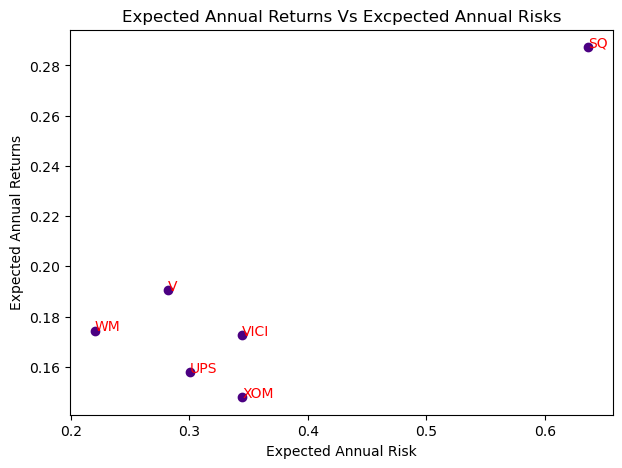

In [10]:
# visually show the ecpected annual returns vs the expected annual risk
risk_df.hvplot.bar()

fig, ax = plt.subplots(figsize=(7,5))
plt.title('Expected Annual Returns Vs Excpected Annual Risks')
ax.scatter(risk_df['Expected Annual Risk'], risk_df['Expected Annual Returns'], c = "indigo")
ax.set_xlabel('Expected Annual Risk')
ax.set_ylabel('Expected Annual Returns')
          
# note the points on plot
for idx, row in risk_df.iterrows():
    ax.annotate(row["Stock"], (row['Expected Annual Risk'], row['Expected Annual Returns']), c = 'red')
plt.savefig('images/portfolio_risk_return.png')

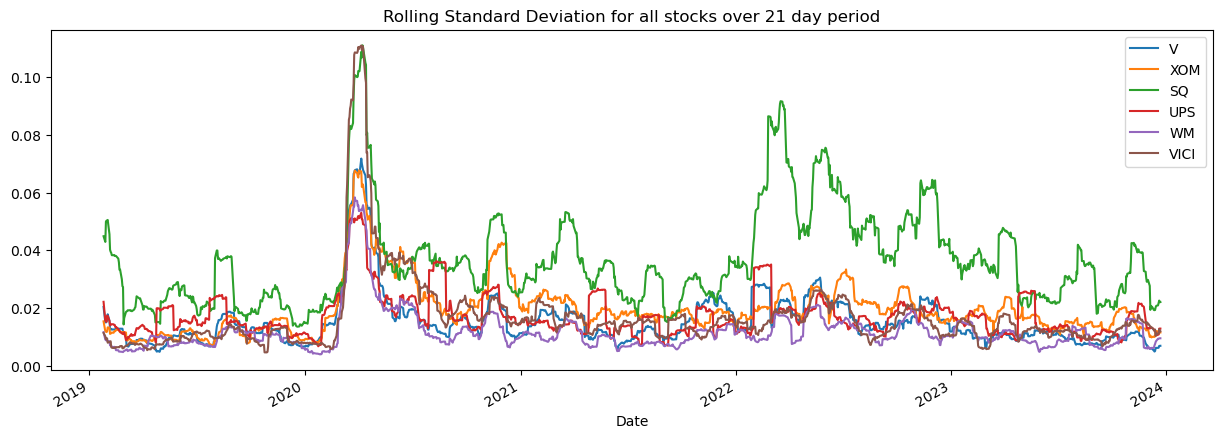

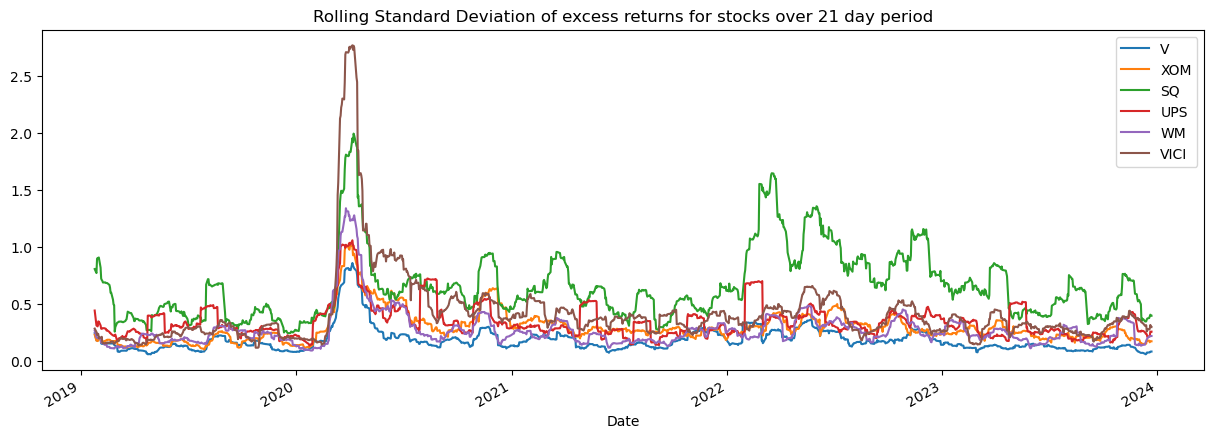

In [11]:
# Calculate the rolling standard deviation for all portfolios using a 21-day window
rolling_std = portfolio_returns.rolling(window=21).std()
excess_rolling_std = excess_returns.rolling(window=21).std()

# Plot the rolling standard deviation
rolling_std.plot(figsize=(15,5), title= 'Rolling Standard Deviation for all stocks over 21 day period')
# Plotting excess
excess_rolling_std.plot(figsize=(15,5), title= 'Rolling Standard Deviation of excess returns for stocks over 21 day period')
plt.savefig('images/standard_deviation.png')
plt.savefig('images/excess_return.png')

In [194]:
# calculte the sharpe ratio -- sharpe ratio lower than 1 is bad, 1 is ok, 3 is the best
sharpe_ratio = np.sqrt(252) * portfolio_returns / portfolio_returns_std

# calculating the sharpe ratio of our excess returns
sharpe_ratio_portfolio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()

# plot the stocks sharpe ratio
sharpe_ratio.hvplot.bar().opts(yformatter='%.0f',
                                      active_tools=[])

:Bars   [Date,Variable]   (value)

<Axes: title={'center': 'Portfolio Correlation vs SP 500'}>

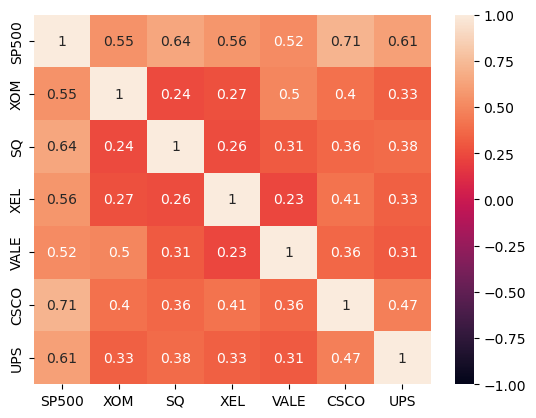

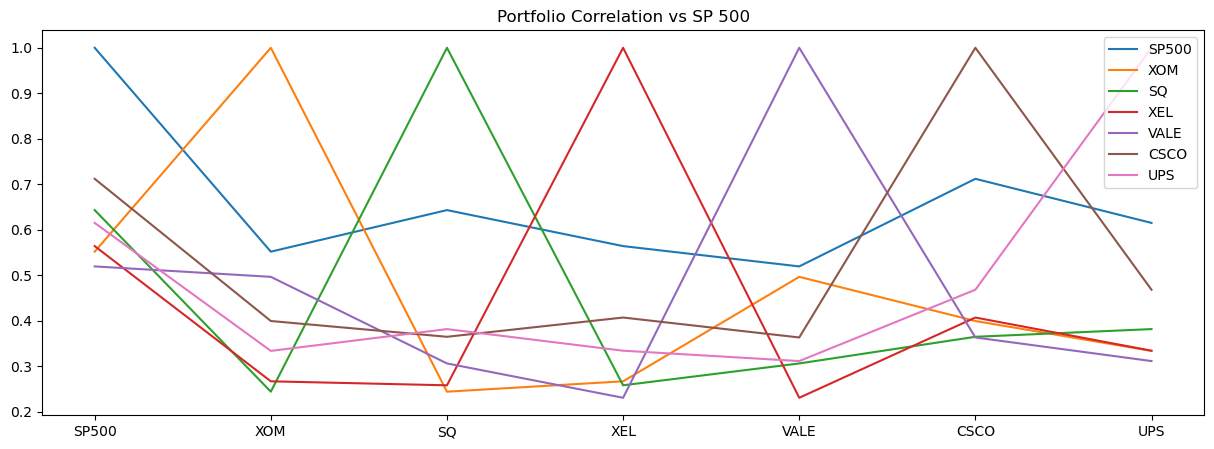

In [196]:
# Calculate the correlation
correlation_matrix = combined_returns.corr()
# Display de correlation matrix
sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True)
correlation_matrix.plot(figsize=(15,5), title='Portfolio Correlation vs SP 500')

In [12]:
# Calculate portflio weight
portfolio_weights = [(percentage / 100) for percentage in portfolio_summary['Percentage'].tolist()]

portfolio_tickers = list(portfolio.keys())
stock_shares = list(portfolio.values())

# Create empty disctionaty for portfolio data to save all downloaded data.
# Run "for" loop to iterate through each stock ticker in the list and 
# download all data in defined period of time.

portfolio_data = {}
for stock_symbol in portfolio.keys():
    stock_data = yf.download(stock_symbol, period="5y")
    portfolio_data[stock_symbol] = stock_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [176]:
portfolio

{'SQ': 30.0, 'AMZN': 20.0, 'AAPL': 15.0, 'XOM': 20.0, 'HD': 12.0, 'MA': 20.0}

In [26]:
# Concatenate portfolio data, concatenate along the columns and asign keys for each stock
portfolio_data_df = pd.concat(portfolio_data.values(),  axis=1, keys=portfolio_data.keys())

# Change column names to upper case for tickers and lower case for definition
portfolio_data_df.columns = portfolio_data_df.columns.map(lambda x: (x[0].upper(), x[1].lower()))


# Difine number of simulation
num_sims = 500

# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10years = MCSimulation(
    portfolio_data = portfolio_data_df,
    weights = portfolio_weights,
    num_simulation = num_sims,
    num_trading_days = 252*10
)
MC_10years.portfolio_data.dropna()

V                                                  \
                  open        high         low       close   adj close   
Date                                                                     
2018-12-26  123.019997  130.240005  123.000000  130.229996  125.863724   
2018-12-27  127.989998  132.009995  126.519997  132.009995  127.584045   
2018-12-28  133.080002  133.619995  129.660004  130.940002  126.549934   
2018-12-31  131.679993  132.440002  130.229996  131.940002  127.516434   
2019-01-02  130.000000  133.740005  129.600006  132.919998  128.463547   
...                ...         ...         ...         ...         ...   
2023-12-18  258.700012  259.589996  257.950012  258.369995  258.369995   
2023-12-19  258.609985  260.339996  257.200012  259.989990  259.989990   
2023-12-20  260.500000  260.820007  257.079987  257.109985  257.109985   
2023-12-21  257.510010  259.989990  257.040009  259.540009  259.540009   
2023-12-22  260.000000  261.209991  258.220001  258.429993  258.429993   

                                          XOM                          ...  \
              volume daily_return        open        high         low  ...   
Date                                                                   ...   
2018-12-26  13499500     0.069827   66.180000   68.660004   64.650002  ...   
2018-12-27  10883000     0.013668   67.739998   68.940002   66.080002  ...   
2018-12-28   7381300    -0.008105   69.180000   69.580002   67.820000  ...   
2018-12-31   7976000     0.007637   68.320000   69.150002   67.660004  ...   
2019-01-02   8788000     0.007428   67.349998   69.870003   67.260002  ...   
...              ...          ...         ...         ...         ...  ...   
2023-12-18   6041100     0.001318  102.129997  103.110001  101.519997  ...   
2023-12-19   8731200     0.006270  102.000000  103.190002  101.790001  ...   
2023-12-20   7240900    -0.011077  103.500000  103.940002  101.129997  ...   
2023-12-21   6246700     0.009451  101.470001  102.010002  100.809998  ...   
2023-12-22   5111500    -0.004277  102.309998  102.940002  101.820000  ...   

                    WM                             VICI                        \
             adj close   volume daily_return       open       high        low   
Date                                                                            
2018-12-26   79.685051  1480300     0.038710  18.100000  18.600000  17.889999   
2018-12-27   80.748253  2007300     0.013342  18.150000  18.350000  17.639999   
2018-12-28   80.610771  1642600    -0.001703  18.410000  18.610001  18.230000   
2018-12-31   81.563965  1281100     0.011825  18.559999  18.780001  18.379999   
2019-01-02   81.316513  1919100    -0.003034  18.610001  18.650000  18.330000   
...                ...      ...          ...        ...        ...        ...   
2023-12-18  177.630005  1807800     0.017645  31.469999  31.610001  31.195000   
2023-12-19  176.779999  1322100    -0.004785  31.360001  32.040001  31.350000   
2023-12-20  175.759995  1049700    -0.005770  31.360001  31.690001  31.090000   
2023-12-21  176.809998  1061300     0.005974  31.350000  31.545000  31.129999   
2023-12-22  176.949997  1291100     0.000792  31.490000  31.674999  31.170000   

                                                        
                close  adj close   volume daily_return  
Date                                                    
2018-12-26  18.590000  14.121107  5455900     0.031632  
2018-12-27  18.350000  14.158138  4592000    -0.012910  
2018-12-28  18.570000  14.327883  3207300     0.011989  
2018-12-31  18.780001  14.489913  3522000     0.011309  
2019-01-02  18.480000  14.258443  3745600    -0.015975  
...               ...        ...      ...          ...  
2023-12-18  31.230000  30.822437  6166400    -0.003510  
2023-12-19  31.799999  31.384998  7017500     0.018252  
2023-12-20  31.120001  31.120001  7103400    -0.021384  
2023-12-21  31.420000  31.420000  6926400     0.009640  
2023-12-22  31.

In [25]:
# Run monte carlo simulation
MC_10years.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.032074,0.983484,1.006079,0.987884,0.986820,0.998043,1.009639,1.001212,1.003917,1.011558,...,0.987650,0.997239,1.020801,1.001872,1.000622,0.996124,0.987436,0.999162,0.999812,0.991118
2,1.040884,0.968686,1.015743,0.971391,0.993212,1.005094,1.013949,0.999265,0.996270,0.996981,...,0.984987,1.009871,1.035156,1.018678,1.016809,0.996559,0.985677,0.991519,0.999585,0.983193
3,1.032577,0.955115,1.002094,0.967011,1.000012,1.007368,1.020026,1.008296,1.006710,1.000641,...,0.989822,1.012753,1.020341,1.024541,1.003129,0.989000,0.980956,0.994316,1.024533,1.002107
4,1.038329,0.943980,1.003428,0.967092,0.987807,1.036882,1.016590,1.023956,0.997272,1.008369,...,0.999283,1.026264,1.022775,1.044686,1.012107,0.976241,0.957673,0.986975,1.049675,1.017139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,4.880298,3.706650,8.958634,3.559010,3.921859,1.655243,7.780445,5.694184,5.215868,5.723218,...,2.401797,12.257118,1.963672,10.200659,9.879909,9.571934,9.378753,13.575227,7.181321,8.901435
2517,4.851829,3.714840,8.954173,3.517598,3.948767,1.661222,7.863481,5.713980,5.142994,5.629286,...,2.449286,12.423751,1.930975,10.107370,9.816016,9.571833,9.290098,13.557588,7.213308,8.789557
2518,4.882331,3.725640,8.945169,3.527370,3.954009,1.695801,7.920864,5.828156,5.113689,5.729374,...,2.452917,12.378770,1.919318,10.011672,9.889977,9.420147,9.259719,13.567076,7.046956,8.783807
2519,4.967981,3.729085,8.836300,3.502217,3.895867,1.725735,7.914024,5.700335,5.095551,5.621971,...,2.483918,12.361460,1.955485,9.912190,9.997504,9.551457,9.370160,13.561528,7.004329,8.941966


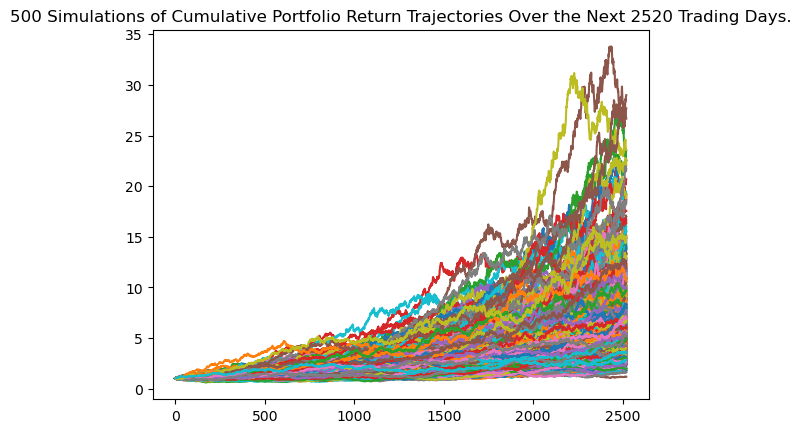

In [16]:
# Plot simulation outcomes 
line_plot = MC_10years.plot_simulation()

# Save the plot for future usage
line_plot.get_figure().savefig("images/Monte_Carlo_10_year", bbox_inches="tight")

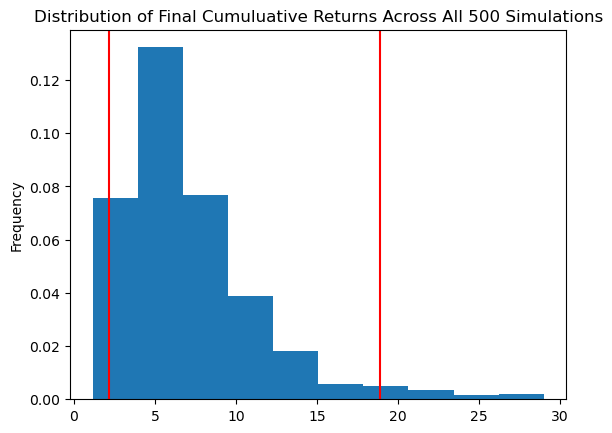

In [17]:
# Plot probability distribution and confidence intervals
distribution_plot = MC_10years.plot_distribution()

# Save the plot for future usage
distribution_plot.get_figure().savefig('images/Monte_Carlo_10year_dist_plot.png',bbox_inches='tight')

In [18]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_summary = MC_10years.summarize_cumulative_return()

# Print summary statistics
print(MC_summary)

count           500.000000
mean              7.151571
std               4.277639
min               1.168573
25%               4.250637
50%               6.042682
75%               8.767217
max              28.991913
95% CI Lower      2.185422
95% CI Upper     18.919421
Name: 2520, dtype: float64


In [23]:
# Set initial investment
initial_investment_10year = current_portfolio_value

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes.
ci_lower_ten = round(MC_summary[8]*initial_investment_10year,2)
ci_upper_ten = round(MC_summary[9]*initial_investment_10year,2)
ci_average_ten = round((ci_lower_ten + ci_upper_ten)/2,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_10year} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_thirty} and ${ci_upper_thirty}")
print(f" On average ${ci_average_ten}")

There is a 95% chance that an initial investment of $14036.679889678955 in the portfolio over the next 10 years will end within in the range of $30676.07 and $265565.85
 On average $148120.96


In [24]:
# Calculate annual return and annual percetage return on average. 
annual_return_10 = ((ci_average_ten - initial_investment_10year) / 10)
annual_percent_10 = annual_return_10 / initial_investment_10year


print(f"Annual Percent Change (10 years): {annual_percent_10 * 100:.2f}%")

Annual Percent Change (10 years): 95.52%
